In [1]:
import time
import sys
import os

if sys.platform == "win32":
    # On Windows, the best timer is time.clock()
    default_timer = time.clock
else:
    # On most other platforms the best timer is time.time()
    default_timer = time.time

In [2]:
# imported lib that are not pytorch related

import matplotlib.pyplot as plt
import json
from PIL import Image
import sys

from tqdm import tqdm # progress bar

In [3]:
# PyTorch imports 

import torch


from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


from torchvision.io import read_image
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

import torch.optim as optim

from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device : {device}")

Device : cuda


In [4]:
dict_superclass_only = {
    0: "Culture",
    1: "Harbor",
    2: "Nature",
    3: "Entertainment",
    4: "Commercial Zone",
    5: "Residential Zone",
    6: "City Infrastructure",
}

dict_class = {
     0: 'Street art',
     1: 'Modern architecture',
     2: 'Historic buildings',
     3: 'Statues/Sculptures',
     4: 'Bridge',
     5: 'Ships/Boats',
     6: 'Seawater',
     7: 'Dock cleat',
     8: 'Dock',
     9: 'Park',
     10: 'Trees',
     11: 'Pond/River',
     12: 'Bush',
     13: 'Sport fields',
     14: 'Stadium',
     15: 'Playground/outdoor workout',
     16: 'Bar/Pub',
     17: 'Supermarket',
     18: 'Mall',
     19: 'Stores',
     20: 'Restaurants/Cafe',
     21: 'Pedestrian street',
     22: 'Hotel',
     23: 'Apartment building',
     24: 'Fence/Walls/hedges',
     25: 'Garden',
     26: 'House',
     27: 'Bus stop',
     28: 'Parking area',
     29: 'Urban greening',
     30: 'Transport hub',
     31: 'Hospital/police stations'
}

full_dataset = False


if full_dataset:
    num_of_classes = len(dict_class)
    dict_ml = dict_class
    string_dataset_train = 'train_all_classes'
    string_dataset_val = 'val_all_classes'
else:
    num_of_classes = len(dict_superclass_only)
    dict_ml = dict_superclass_only
    string_dataset_train = 'train'
    string_dataset_val = 'test'
    
print(f'number of classes for entire dataset:{num_of_classes}')

number of classes for entire dataset:7


In [5]:
class CustomDataset(Dataset):
    def __init__(self, json_file, root_dir, num_classes, transform=None):
        self.json_file = json_file
        self.root_dir = root_dir
        self.num_classes = num_classes
        self.transform = transform
        
        with open(json_file, 'r') as f:
            self.data = json.load(f)
            
    def __len__(self):
            return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data[idx]['image_data'])
        # Replace "images" with "jpg_cut" in the img_name
        img_name = img_name.replace("/images", "/jpg")
        image = Image.open(img_name)
        annotations = [int(x) for x in self.data[idx]['annotations']]
        
        # Convert annotations to tensor and multi-label encode
        label_tensor = torch.zeros(self.num_classes)
        for label in annotations:
            label_tensor[label] = 1
        
        if self.transform:
            image = self.transform(image)
        
        return {'image': image, 'annotations': label_tensor}

    def class_distribution(self):
        # Initialize a tensor to hold the count of each class
        class_counts = torch.zeros(self.num_classes)

        # Iterate through the dataset and count each class
        for item in self.data:
            annotations = [int(x) for x in item['annotations']]
            for label in annotations:
                class_counts[label] += 1

        return class_counts
        
    def class_weights(self):
        class_counts = self.class_distribution()
        total_samples = len(self.data)
        
        # Compute the weight for each class
        weights = total_samples / (self.num_classes * class_counts)
#         print(total_samples)
#         print(self.num_classes)
#         print(class_counts)
        
        # Handle cases where class_counts is zero to avoid division by zero
        weights[class_counts == 0] = 0
        
        return weights

In [6]:
transform_val = v2.Compose([
#     v2.Resize((512, 512)),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_train = v2.Compose([
#     v2.Resize((512, 512)),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(contrast=0.1, saturation=0.1),
    v2.RandomAdjustSharpness(0.1, p=0.5),
    v2.RandomEqualize(p=0.5),
])

if full_dataset:
    train_dataset = CustomDataset(json_file=f'/kaggle/input/aalborg-street-view-images/{string_dataset_train}.json', root_dir=r'/kaggle/input/aalborg-street-view-images/Pictures', num_classes=num_of_classes, transform=transform_train)
    val_dataset = CustomDataset(json_file=f'/kaggle/input/aalborg-street-view-images/{string_dataset_val}.json', root_dir=r'/kaggle/input/aalborg-street-view-images/Pictures', num_classes=num_of_classes, transform=transform_val)
else:    
    train_dataset = CustomDataset(json_file=f'/kaggle/input/aalborg-street-view-images/Pictures/{string_dataset_train}.json', root_dir=r'/kaggle/input/aalborg-street-view-images/Pictures', num_classes=num_of_classes, transform=transform_train)
    val_dataset = CustomDataset(json_file=f'/kaggle/input/aalborg-street-view-images/Pictures/{string_dataset_val}.json', root_dir=r'/kaggle/input/aalborg-street-view-images/Pictures', num_classes=num_of_classes, transform=transform_val)

workers = 4
batch_size = 32

dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    persistent_workers=True,
    prefetch_factor=4
)

dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    persistent_workers=True,
    prefetch_factor=4
)

print(train_dataset.class_distribution())


for batch in dataloader_train:
    data, labels = batch['image'], batch['annotations']
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    break  # Break after printing the first batch to avoid printing too much

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


tensor([ 7413.,  1980.,  6087.,   694.,  9954., 29119., 22283.])
Data shape: torch.Size([32, 3, 512, 512])
Labels shape: torch.Size([32, 7])


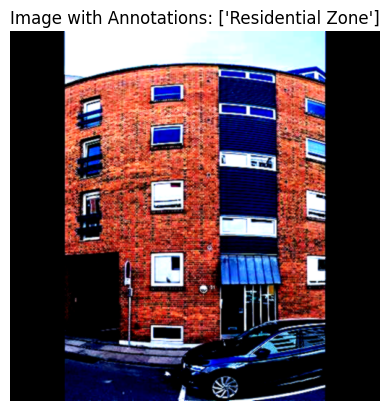

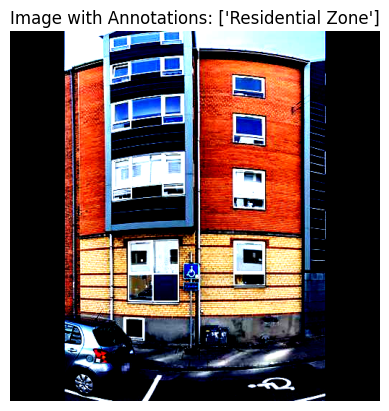

In [7]:
printer = True

if printer:

    %matplotlib inline

    # Define a function to display the image with annotations and labels
    def show_image_with_annotations_and_labels(sample, class_dict):
        image = sample['image']
        annotations = sample['annotations']

        # Convert one-hot encoded annotations to indices
        labels = [i for i, label in enumerate(annotations) if label == 1]

        # Convert image tensor to numpy array and transpose channels
        image = image.permute(1, 2, 0).numpy()

        # Display the image
        plt.imshow(image)

        # Display annotations and labels (if any)
        if labels:
            class_names = [class_dict[label] for label in labels]
            plt.title(f'Image with Annotations: {class_names}')
        else:
            plt.title('Image without Annotations')

        plt.axis('off')
        plt.show()

    # Get a sample from the dataset
    sample_train = train_dataset[3]  # Change the index as needed
    sample_val = val_dataset[3]

    # Show the image with annotations and labels
    show_image_with_annotations_and_labels(sample_train, dict_ml)
    show_image_with_annotations_and_labels(sample_val, dict_ml)
else: 
    print("Set printer to True to see image example")


In [8]:
class ResNet50(torch.nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = torch.nn.Identity()  # Remove the original fully connected layer
        self.fc = torch.nn.Linear(num_features, num_classes)  # Add a new fully connected layer

    def forward(self, x):
        x = self.resnet50(x)
        x = self.fc(x)
        return x

In [9]:
# Initialize ResNet50 model

print(f"DEBUG CHECK {device}")
model = ResNet50(num_classes=num_of_classes).to(device)

# model = nn.DataParallel(model)
# model.to(device)

DEBUG CHECK cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs,save_dir=None,resume_from=None):
    if resume_from:
        model, optimizer, start_epoch = load_checkpoint(model, optimizer, resume_from)
    else:
        start_epoch = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(start_epoch, + num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        train_loss, train_accuracy , train_true_positives, train_false_positives, train_true_negatives, train_false_negatives, train_precision, train_recall, train_f1_score = train(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_accuracy , val_true_positives, val_false_positives, val_true_negatives, val_false_negatives, val_precision, val_recall, val_f1_score = evaluate(model, val_dataloader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
        
        for i in range(num_of_classes):
            class_name = dict_superclass_only.get(i, f"Class {i}")
            print("-" * 50)
            print("Training parameters")
            print(f'{class_name}: TP={train_true_positives[i]}, FP={train_false_positives[i]}, TN={train_true_negatives[i]}, FN={train_false_negatives[i]}, Precision={train_precision[i]:.4f}, Recall={train_recall[i]:.4f}, F1 Score={train_f1_score[i]:.4f}')
            print("-" * 50)
            print(f'{class_name}: TP={val_true_positives[i]}, FP={val_false_positives[i]}, TN={val_true_negatives[i]}, FN={val_false_negatives[i]}, Precision={val_precision[i]:.4f}, Recall={val_recall[i]:.4f}, F1 Score={val_f1_score[i]:.4f}')
            print("-" * 50) 
        
        if save_dir:
            output_file_path = os.path.join(save_dir, f"training_outputs_{epoch + 1}_{num_epochs}.txt")
            with open(output_file_path, "w") as output_file:
                output_file.write(f"Epoch {epoch + 1}/{num_epochs}\n")
                output_file.write(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
                                  f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}\n")
                
                for i in range(num_of_classes):
                    class_name = dict_superclass_only.get(i, f"Class {i}")
                    output_file.write("-" * 50)
                    output_file.write("\n Training \n")                                      
                    output_file.write(f'\n{class_name}: TP={train_true_positives[i]} | FP={train_false_positives[i]} | TN={train_true_negatives[i]} | FN={train_false_negatives[i]} | Precision={train_precision[i]:.4f} | Recall={train_recall[i]:.4f} | F1 Score={train_f1_score[i]:.4f}\n')
                    output_file.write("-" * 50)
                    output_file.write("\n validation \n") 
                    output_file.write(f'\n{class_name}: TP={val_true_positives[i]} | FP={val_false_positives[i]} | TN={val_true_negatives[i]} | FN={val_false_negatives[i]} | Precision={val_precision[i]:.4f} | Recall={val_recall[i]:.4f} | F1 Score={val_f1_score[i]:.4f}\n')
                    output_file.write("-" * 50) 
        
        if save_dir:
            model_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}_w_{num_of_classes}_classes.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, model_path)
            print(f"Model saved at: {model_path}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print('Loaded checkpoint from epoch {}'.format(epoch))
    return model, optimizer, epoch

In [12]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Get number of classes from the first batch
    batch = next(iter(dataloader))
    num_classes = batch['annotations'].shape[1]
    
    print(num_classes)
    # Initialize metrics for each class
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    true_negatives = [0] * num_classes
    false_negatives = [0] * num_classes

    for batch in dataloader:
        inputs, labels = batch['image'].to(device), batch['annotations'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Convert outputs to binary predictions using thresholding
        predicted = (outputs > 0.0).float()


        for i in range(num_classes):
            # Calculate TP, FP, TN, FN for each class
            true_positives[i] += ((predicted[:, i] == 1) & (labels[:, i] == 1)).sum().item()
            false_positives[i] += ((predicted[:, i] == 1) & (labels[:, i] == 0)).sum().item()
            true_negatives[i] += ((predicted[:, i] == 0) & (labels[:, i] == 0)).sum().item()
            false_negatives[i] += ((predicted[:, i] == 0) & (labels[:, i] == 1)).sum().item()

        # Calculate accuracy
        total_predictions += labels.size(0) * num_classes
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_accuracy = correct_predictions / total_predictions

    # Calculate precision, recall, and F1 score for each class
    precision = [0] * num_classes
    recall = [0] * num_classes
    f1_score = [0] * num_classes
    
    for i in range(num_classes):
        if true_positives[i] + false_positives[i] > 0:
            precision[i] = true_positives[i] / (true_positives[i] + false_positives[i])
        if true_positives[i] + false_negatives[i] > 0:
            recall[i] = true_positives[i] / (true_positives[i] + false_negatives[i])
        if precision[i] + recall[i] > 0:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    return train_loss, train_accuracy, true_positives, false_positives, true_negatives, false_negatives, precision, recall, f1_score

In [13]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    batch = next(iter(dataloader))
    num_classes = batch['annotations'].shape[1]
    
    # Initialize metrics for each class
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    true_negatives = [0] * num_classes
    false_negatives = [0] * num_classes
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['image'].to(device), batch['annotations'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  
            running_loss += loss.item() 
            
            # Convert outputs to binary predictions using thresholding
            predicted = (outputs > 0.0).float()

            for i in range(num_classes):
                # Calculate TP, FP, TN, FN for each class
                true_positives[i] += ((predicted[:, i] == 1) & (labels[:, i] == 1)).sum().item()
                false_positives[i] += ((predicted[:, i] == 1) & (labels[:, i] == 0)).sum().item()
                true_negatives[i] += ((predicted[:, i] == 0) & (labels[:, i] == 0)).sum().item()
                false_negatives[i] += ((predicted[:, i] == 0) & (labels[:, i] == 1)).sum().item()

    
            total_predictions += labels.size(0) * num_classes
            correct_predictions += (predicted == labels).sum().item()

        val_loss = running_loss / len(dataloader)
        val_accuracy = correct_predictions / total_predictions
    
        # Calculate accuracy
        total_predictions += labels.size(0) * num_classes
        correct_predictions += (predicted == labels).sum().item()
        
        # Calculate precision, recall, and F1 score for each class
        precision = [0] * num_classes
        recall = [0] * num_classes
        f1_score = [0] * num_classes
        
        for i in range(num_classes):
            if true_positives[i] + false_positives[i] > 0:
                precision[i] = true_positives[i] / (true_positives[i] + false_positives[i])
            if true_positives[i] + false_negatives[i] > 0:
                recall[i] = true_positives[i] / (true_positives[i] + false_negatives[i])
            if precision[i] + recall[i] > 0:
                f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    return  val_loss, val_accuracy, true_positives, false_positives, true_negatives, false_negatives, precision, recall, f1_score


In [14]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = 25

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
resume= False
save_dir = r"/kaggle/working/"
epoch = 1

if resume:
    resume_from = f"/kaggle/working/model_epoch_{epoch}.pt"
    train_model(model, dataloader_train, dataloader_train, criterion, optimizer, device, num_epochs, save_dir, resume_from)
else:
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device, num_epochs,save_dir)


Epoch 1/25
7
Train Loss: 0.3631 | Train Accuracy: 0.8384 | Val Loss: 0.5051 | Val Accuracy: 0.8172
--------------------------------------------------
Training parameters
Culture: TP=421, FP=438, TN=29540, FN=6992, Precision=0.4901, Recall=0.0568, F1 Score=0.1018
--------------------------------------------------
Culture: TP=82, FP=106, TN=3648, FN=839, Precision=0.4362, Recall=0.0890, F1 Score=0.1479
--------------------------------------------------
--------------------------------------------------
Training parameters
Harbor: TP=130, FP=52, TN=35359, FN=1850, Precision=0.7143, Recall=0.0657, F1 Score=0.1203
--------------------------------------------------
Harbor: TP=4, FP=0, TN=4410, FN=261, Precision=1.0000, Recall=0.0151, F1 Score=0.0297
--------------------------------------------------
--------------------------------------------------
Training parameters
Nature: TP=2853, FP=1176, TN=30128, FN=3234, Precision=0.7081, Recall=0.4687, F1 Score=0.5641
------------------------------